# Sprocket

Sprocket identifies high-value new customers for the hypothetical bike company Sprocket Central Pty Ltd. A model will be created to predict the amount of profit generated by each current customer, based on customer demographic information. The model will be utilized to project which new customers will generate the most profit for the company.

After reading in data about current customer information from multiple data frames, the data will be joined and cleaned to create a compiled data frame consisting of all current customer information. Then, an exploratory data analysis (EDA) will be performed to determine which features to include in the prediction model. Next, a data pipeline will be created to process the data before it is used by multiple prediction models (a decision tree model, a random forest model, and three gradient boosted models). The prediction models will be evaluated using cross-validation. The model with the lowest mean absolute error (MAE) will be applied to the new customer data frame to determine the highest-valued new customers.

#   
## Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import xgboost as xgb
import lightgbm as lgb

#   
## Data Sets

All the data for this project was collected from [InsideSherpa](https://www.theforage.com/login?loginWithToken=cQYJkeAiraFbBaUzLqoF_xH4S-IZctid3Jm_rJ2xoJE&redirectTo=virtual-internships/m7W4GMqeT3bh9Nb2c):

1. The **Transactions** data set presents information about *20,000* transactions including the transaction ID, customer ID, list price, and cost.
2. The **Customer Demographic** data set presents information about *4000* customers including their customer ID, name, gender, date of birth, job industry, tenure, wealth segment, number of past bike related purchases, and whether they own a car.
3. The **Customer Address** data set presents location information about *4000* customers such as the state the customer lives in.
4. The **New Customer** data set presents information about *1000* new customers such as their name, gender, date of birth, job industry, tenure, wealth segment, location (state), number of past bike related purchases, and whether they own a car.


#### Transactions Data Frame

In [2]:
# Read transactions data frame
transactions_df = pd.read_excel('KPMG_VI_raw_data.xlsx',sheet_name = 'Transactions',skiprows = 1)[['customer_id','list_price',
                                                                                                'standard_cost']]

In [3]:
# Group transactions by customer_id
customer_total = transactions_df.groupby('customer_id').sum()

# Calculate profit by customer
customer_total['profit'] = customer_total['list_price'] - customer_total['standard_cost']
customer_profit = customer_total.drop(['list_price', 'standard_cost'], axis = 1)
    
customer_profit.head()

,profit
customer_id,
1,3018.09
2,2226.26
3,3362.81
4,220.57
5,2394.94


#   
#### Customer Demographic Data Frame

In [4]:
# Read customer demographic data frame
demographic = pd.read_excel('KPMG_VI_raw_data.xlsx', sheet_name = 'CustomerDemographic', index_col = 0, skiprows = 1)

In [5]:
# Drop columns irrelevant to analysis
demographic_df = demographic.drop(['job_title', 'deceased_indicator','default'], axis=1)
demographic_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure
customer_id,,,,,,,,,
1,Laraine,Medendorp,F,93,1953-10-12,Health,Mass Customer,Yes,11.0
2,Eli,Bockman,Male,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0
3,Arlin,Dearle,Male,61,1954-01-20,Property,Mass Customer,Yes,15.0
4,Talbot,NaN,Male,33,1961-10-03,IT,Mass Customer,No,7.0
5,Sheila-kathryn,Calton,Female,56,1977-05-13,NaN,Affluent Customer,Yes,8.0


#   
#### Customer Address Data Frame

In [6]:
# Read customer address data frame
address_df = pd.read_excel('KPMG_VI_raw_data.xlsx', sheet_name = 'CustomerAddress', index_col = 0, 
                           skiprows = 1)[['state']]
address_df.head()

,state
customer_id,
1,New South Wales
2,New South Wales
4,QLD
5,New South Wales
6,VIC


#  
#   
## Data Wranling

 
#### Join Data Frames

I will join the customer address data frame to the customer demographic data frame by customer id to create a customer attribute data frame. Then, I will join the customer attribute data frame with the transaction data frame by customer id. This will be the final compiled data frame that will be used to create the prediction models.

In [7]:
customer_attribute = pd.concat([demographic_df, address_df], axis=1, join='outer')

I decided to outer join the two data frames rather than inner join because these data frames only consist of predictor variables and any missing values will be imputed later in the analysis.

Now, I will join the customer attribute data frame with the transaction data frame by customer id. I decided to inner join these data frames because it contains the target variable (profit) which is required to create a prediction model. If I were to outer join these data frames, it may result in some entries have a missing target variable.

In [8]:
current_customers = pd.concat([customer_attribute, customer_profit], axis=1, join='inner')

#   
#### Data Cleaning

There are numerous data cleaning procedures that need to be performed to make the data easier to work with prior to analysis.

Data Cleaning Steps:
* Combine first name and last name
* Fix inconsistent gender data entries (i.e. change 'F' to 'Female' and 'M' to 'Male')
* Calculate age from date of birth (DOB)
* Change age outlier
* Fix inconsistent state data entries (i.e. change 'NSW' to 'New Soth Wales', 'QLD' to 'Queensland', and 'VIC' to 'Victoria')
* Rename long column names

In [9]:
def clean_data(df):
    
    # Combine first name and last name
    last_name = df['last_name']
    last_name.fillna(" ", inplace=True)
    df['name'] = df['first_name'] + " " + df['last_name']

    # Uniform genders
    df.loc[df['gender'] == 'F', 'gender'] = 'Female'
    df.loc[df['gender'] == 'Femal', 'gender'] = 'Female'
    df.loc[df['gender'] == 'M', 'gender'] = 'Male'
    df.loc[df['gender'] == 'U', 'gender'] = 'Unknown'

    # Calculate age from date of birth (DOB)
    now = pd.to_datetime('now')
    df['age'] = (now - df['DOB']).astype('<m8[Y]')

    # Change age outlier
    df.loc[df['age'] == 176, 'age'] = 76

    # Uniform state values
    df.loc[df['state'] == 'NSW', 'state'] = 'New South Wales'
    df.loc[df['state'] == 'QLD', 'state'] = 'Queensland'
    df.loc[df['state'] == 'VIC', 'state'] = 'Victoria'

    # Rename columns
    df = df.rename(columns={'past_3_years_bike_related_purchases': 'past_related_purchases',
                            'job_industry_category': 'job_industry'})
    
    return df

In [10]:
# Clean customer data frame
customer_df = clean_data(current_customers)

# Select columns relevant to analysis
customer_df = customer_df[['name','gender','age','job_industry','tenure','wealth_segment','past_related_purchases',
                           'state','owns_car','profit']]
customer_df.head()

,name,gender,age,job_industry,tenure,wealth_segment,past_related_purchases,state,owns_car,profit
customer_id,,,,,,,,,,
1,Laraine Medendorp,Female,66.0,Health,11.0,Mass Customer,93.0,New South Wales,Yes,3018.09
2,Eli Bockman,Male,39.0,Financial Services,16.0,Mass Customer,81.0,New South Wales,Yes,2226.26
3,Arlin Dearle,Male,66.0,Property,15.0,Mass Customer,61.0,NaN,Yes,3362.81
4,Talbot,Male,58.0,IT,7.0,Mass Customer,33.0,Queensland,No,220.57
5,Sheila-kathryn Calton,Female,43.0,NaN,8.0,Affluent Customer,56.0,New South Wales,Yes,2394.94


#   
#### Missing Data

About 2% of customers have a missing age and/or tenure. In addition, about 16% of customers have a missing job industry category and 0.1% have a missing state. Since this is a substantial amount of data, I cannot simply remove these entries. Instead, I will use an imputer during model development to change missing ages and tenures to their respective median value and set missing job industries and states to 'Other'.

In [11]:
# Percentage of data with null values
customer_df.isnull().sum()/len(customer_df.index)

name                      0.000000
gender                    0.000000
age                       0.021758
job_industry              0.160607
tenure                    0.021758
wealth_segment            0.000000
past_related_purchases    0.000000
state                     0.001145
owns_car                  0.000000
profit                    0.000000
dtype: float64

#   
#   
## Exploratory Data Analysis (EDA)

To determine which features to include in my model, I will analyze the relationship between each possible predictor variable and the target variable (profit). Ideally, I am looking for variables that will clearly differentiate the amount of profit produced by a customer.

#### Possible Numerical Predictor Variables

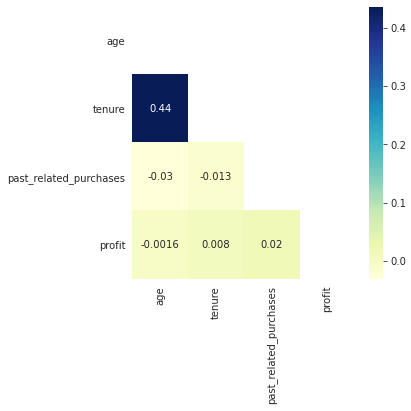

In [12]:
# Correlation matrix
correlations = customer_df.corr()

# Heat map of correlation matrix
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(correlations,mask=mask,annot=True,cmap="YlGnBu")

There appears to be no correlation between profit and: age, tenure, past related purchases. Now, I will take a look at the average profit by each possible predictor variable.

Text(0, 0.5, 'Average Profit')

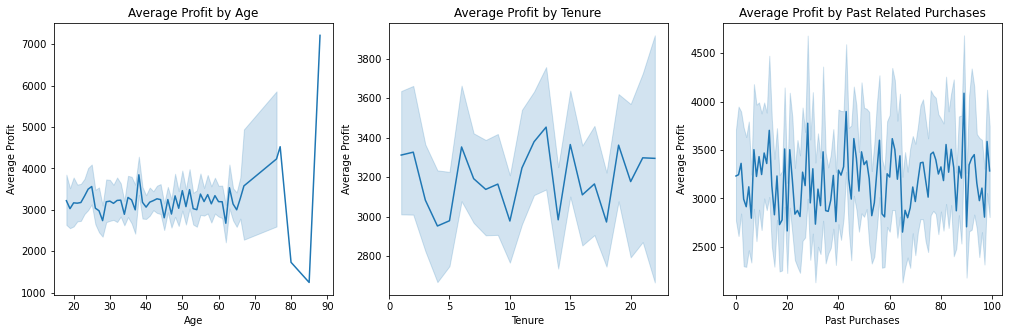

In [13]:
fig, ax = plt.subplots(1,3,figsize=(17, 5))

# Scatter plot showing average profit by job industry
plt.subplot(1,3,1)
plt.title("Average Profit by Age")
sns.lineplot(x='age', y='profit', data=customer_df)
plt.xlabel("Age")
plt.ylabel("Average Profit")

# Scatter plot showing average profit by gender
plt.subplot(1, 3, 2)
plt.title("Average Profit by Tenure")
sns.lineplot(x='tenure', y='profit', data=customer_df)
plt.xlabel("Tenure")
plt.ylabel("Average Profit")

# Scatter plot showing average profit by number of past related purchases
plt.subplot(1,3,3)
plt.title("Average Profit by Past Related Purchases")
sns.lineplot(x='past_related_purchases', y='profit', data=customer_df)
plt.xlabel("Past Purchases")
plt.ylabel("Average Profit")

Age, tenure, and past purchases seem to do a decent job of differentiating a customer's average profit. Specifically, customers in their early 20s and 65+ appear to generate more profit, on average, than those in between age 30 to 60. In addition, customers with a longer tenure and more past bike related purchases appear to generate more profit, on average.

#### Possible Categorical Predictor Variables

Text(0.5, 0, 'Average Profit')

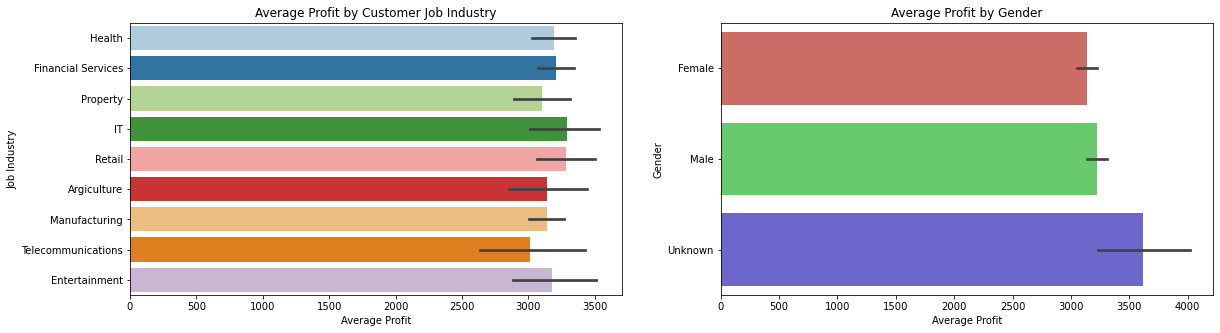

In [14]:
fig, ax = plt.subplots(1,2,figsize=(30, 5))

# Bar chart showing average profit by job industry
plt.subplot(1,3,1)
plt.title("Average Profit by Customer Job Industry")
sns.barplot(y='job_industry', x='profit', data=customer_df, palette="Paired", orient='h')
plt.ylabel("Job Industry")
plt.xlabel("Average Profit")

# Bar chart showing average profit by gender
plt.subplot(1, 3, 2)
plt.title("Average Profit by Gender")
sns.barplot(y='gender', x='profit', data=customer_df, palette="hls", orient='h')
plt.ylabel("Gender")
plt.xlabel("Average Profit")

Job industry and gender also seem to effectively differentiate average customer profit. Customers working in the IT, Retail, Financial Services, Health, and Entertainment industries  appear to generate more profit, on average, than those in other industries. In addition, male customers appear to generate more profit, on average, than female customers.

Text(0, 0.5, 'Average Profit')

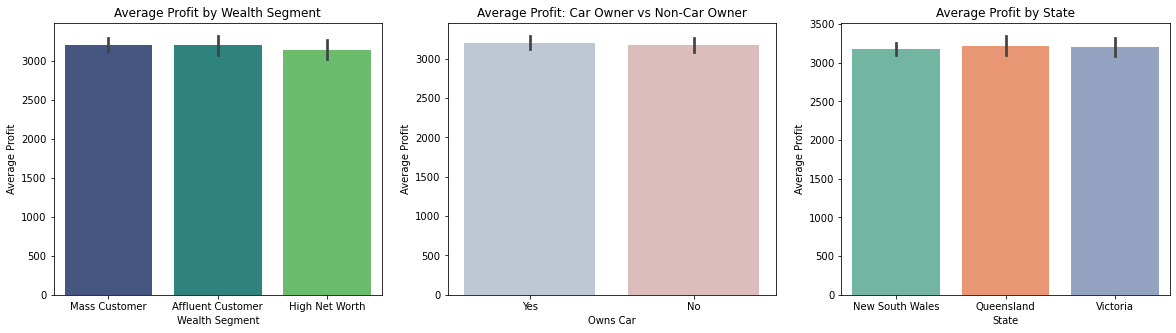

In [15]:
fig, ax = plt.subplots(1,3,figsize=(20, 5))

# Bar chart showing average profit by wealth segment
plt.subplot(1, 3, 1)
plt.title("Average Profit by Wealth Segment")
sns.barplot(x='wealth_segment', y='profit', data=customer_df, palette="viridis")
plt.xlabel("Wealth Segment")
plt.ylabel("Average Profit")

# Bar chart showing average profit based on car ownership
plt.subplot(1, 3, 2)
plt.title("Average Profit: Car Owner vs Non-Car Owner")
sns.barplot(x='owns_car', y='profit', data=customer_df, palette="vlag")
plt.xlabel("Owns Car")
plt.ylabel("Average Profit")

# Bar chart showing average profit by state
plt.subplot(1, 3, 3)
plt.title("Average Profit by State")
sns.barplot(x='state', y='profit', data=customer_df, palette="Set2")
plt.xlabel("State")
plt.ylabel("Average Profit")

#   
#### Feature Selection

Based on the EDA, I will include the following features in my prediction model: gender, age, job industry, tenure, and past related purchases. I have chosen not to include wealth segment, car ownership, and state because there is not much difference in average profit across customers in those features.

In [16]:
# Select features to include in prediction model
customer_df = customer_df[['name','gender','age','job_industry','tenure','past_related_purchases','profit']]

#   
#    
## Model Development

 
#### Data Preprocessing Setup

I will split the data into a training set (80% of the data) and a validation set (20% of the data). The training set will be used by the prediction models to learn from and the validation set will be used to test the model's accuracy. I will also split the categorical and numerical features so they can be processed through the data pipeline.

In [17]:
from sklearn.model_selection import train_test_split

# Select subset of predictors
X = customer_df.drop(['name','profit'], axis = 1)

# Select target
y = customer_df.profit

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Select categorical columns
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

#   
#### Data Preprocessing Pipeline

The data preprocessing pipeline will set null numerical data to their respective median and  null categorical data to "Other". 

The prediction models I will develop only accept numerical values (i.e. non-categorical). Thus, I will use one-hot encoding to convert categorical data into numerical data. Specifically, I will create new columns indicating the presence (1) or absence (0) of each possible value for each categorical variable in the data.

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy = 'median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Other')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#   
#### Prediction Models

I have decided to test five models: a decision tree model, a random forest model, and three gradient boosted models.

In [19]:
# Decision Tree Model
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=0)

# Random Forest Model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# XGBoost Model
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.005)

# GBM Model
from sklearn.ensemble import GradientBoostingRegressor 
gbm_model = GradientBoostingRegressor(random_state=0)

# Light GBM Model
lgbm_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.005)

#   
#### Evaluation of Models

Since the dataset is not very large, I will evaluate each model using cross-validation which consists of running a model on different subsets of the data to get multiple measures of model quality which will produce a more accurate measure. Finally, I will select the model with the lowest average mean absolute error (MAE).

In [20]:
from sklearn.model_selection import cross_val_score

def get_mae(model, X_train, X_valid, y_train, y_val):
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
    model_pipeline.fit(X_train, y_train)
    
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(model_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    
    # Get the average MAE score across the 5 folds of data
    mae = scores.mean()
    
    return(mae)

# Compare mean absolute error (MAE) across different models
for model in [dt_model, rf_model, xgb_model, gbm_model, lgbm_model]:
    my_mae = get_mae(model, X_train, X_valid, y_train, y_valid)
    print("Average MAE Score: %d \t\t\t Model: %s" %(my_mae, str(model).split("(")[0]))

Average MAE Score: 2048 			 Model: DecisionTreeRegressor
Average MAE Score: 1505 			 Model: RandomForestRegressor
Average MAE Score: 1459 			 Model: XGBRegressor
Average MAE Score: 1442 			 Model: GradientBoostingRegressor
Average MAE Score: 1425 			 Model: LGBMRegressor


#   
#### Model Selection

I will use the **Light GBM Model** to predict new customer profit since the LGBM Regressor model has the lowest average MAE. Now, I will analyze which features will impact the Light GBM model the most.

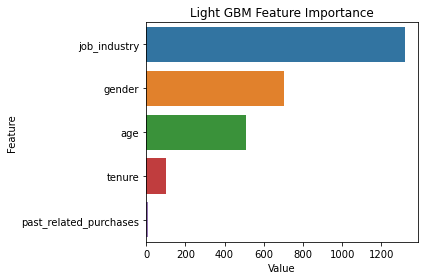

In [21]:
# Deteremine importance of each feature in the Light GBM model
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(6, 4))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Light GBM Feature Importance')
plt.tight_layout()
plt.show()

The model will primarily use the customer's job industry, gender, and age to predict the profit they will generate. Their tenure and past related bike purchases will also have a small impact on the model predictions.

#   
#   
## Model Deploypment

#### New Customer Data Frame

In [22]:
# Read new customer data frame
new_customer = pd.read_excel('KPMG_VI_raw_data.xlsx', sheet_name = 'NewCustomerList',
                                skiprows = 1)[['first_name','last_name','gender','past_3_years_bike_related_purchases','DOB',
                                               'job_industry_category','tenure','state']]

In [23]:
# Clean new customer data frame
new_customer_df = clean_data(new_customer)

# Select model features from new customer data frame
new_customer_df = new_customer_df[['name','gender','age','job_industry','tenure','past_related_purchases']]

new_customer_df.head()

,name,gender,age,job_industry,tenure,past_related_purchases
0,Chickie Brister,Male,63.0,Manufacturing,14,86
1,Morly Genery,Male,50.0,Property,16,69
2,Ardelis Forrester,Female,46.0,Financial Services,10,10
3,Lucine Stutt,Female,41.0,Manufacturing,5,64
4,Melinda Hadlee,Female,55.0,Financial Services,19,34


#   
#### Apply Light GBM Prediction Model to New Customers

In [26]:
# Deploy model pipeline on new customer data set
deploy_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', lgbm_model)
                             ])

# Get new customer profit predictions
new_customer_df['profit_prediction'] = deploy_model_pipeline.predict(new_customer_df.drop('name', axis=1))

#   
#### Predicted High-Value New Customers

In [25]:
new_customer_df.sort_values('profit_prediction', ascending=False).head(10)

,name,gender,age,job_industry,tenure,past_related_purchases,profit_prediction
212,Tabbie Curner,Male,23.0,Retail,6,12,3677.198754
578,Berenice Kaesmakers,Female,25.0,Retail,11,64,3599.476422
843,Melosa McOwan,Female,19.0,Financial Services,12,25,3533.317349
234,Agace Hedge,Female,23.0,NaN,13,25,3533.317349
571,Esdras Birchett,Male,69.0,Entertainment,21,81,3523.925112
803,Bryon Goundry,Male,69.0,Manufacturing,21,79,3523.925112
799,Ansell Tolhurst,Male,71.0,Manufacturing,22,77,3523.925112
914,Launce Gale,Male,81.0,NaN,21,86,3523.925112
878,Lizette McKeaveney,Female,26.0,Health,13,30,3523.791612
97,Karlik Penchen,Male,25.0,Retail,11,60,3521.296526


As you can see, a lot of the demographic information for the predicted high-value new customers is in line with the EDA results. Most of these customers are male and in their early 20s or 65+. In addition, most of them work in the retail, entertainment, financial services, and health industry. Finally, they have been working in their current position for a while (long tenure), and have made many bike related purchases in the past.